In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices()
print(devices)
tf.debugging.set_log_device_placement(True)
a=tf.random.normal([100,100])
b=tf.random.normal([100,100])
c = a*b

2023-06-27 17:41:58.923045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0


2023-06-27 17:42:02.165561: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-27 17:42:02.165598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-27 17:42:02.173929: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:02.173943: I tensorflow/core/common_runtime/placer.cc:114] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:02.173949: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:02.182592: I tensorflow/core/common_ru

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

import keras

In [3]:
# image_dir = Path('/content/drive/MyDrive/AI/.kaggle/20-50') #tell python in which directory the training images are.
image_dir = Path('/Users/crossrunway/DataSets/20-50')

In [4]:
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int32)

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [5]:
images

,Filepath,Age
0,/Users/crossrunway/DataSets/20-50/train/033/16...,33
1,/Users/crossrunway/DataSets/20-50/train/002/24...,2
2,/Users/crossrunway/DataSets/20-50/train/061/88...,61
3,/Users/crossrunway/DataSets/20-50/train/017/15...,17
4,/Users/crossrunway/DataSets/20-50/train/029/14...,29
...,...,...
273635,/Users/crossrunway/DataSets/20-50/test/40/036/...,36
273636,/Users/crossrunway/DataSets/20-50/train/036/91...,36
273637,/Users/crossrunway/DataSets/20-50/train/046/11...,46
273638,/Users/crossrunway/DataSets/20-50/train/23/161...,23


In [6]:
image_df = images.sample(20000, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_df

,Filepath,Age
11408,/Users/crossrunway/DataSets/20-50/train/44/171...,44
3616,/Users/crossrunway/DataSets/20-50/train/030/44...,30
9747,/Users/crossrunway/DataSets/20-50/train/051/17...,51
6915,/Users/crossrunway/DataSets/20-50/train/032/14...,32
4888,/Users/crossrunway/DataSets/20-50/train/027/12...,27
...,...,...
10955,/Users/crossrunway/DataSets/20-50/train/046/71...,46
17289,/Users/crossrunway/DataSets/20-50/train/035/37...,35
5192,/Users/crossrunway/DataSets/20-50/train/024/17...,24
12172,/Users/crossrunway/DataSets/20-50/train/49/168...,49


In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', # kepek
    y_col='Age', # becsülendő életkorok
    target_size=(120, 120), # egy kép mérete
    color_mode='rgb', # 3 csatornás képek, RGB
    class_mode='raw', # mivel a célváltozónk int típusú és nem object
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Age',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 11200 validated image filenames.
Found 2800 validated image filenames.
Found 6000 validated image filenames.


In [10]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in

2023-06-27 17:42:21.709142: I tensorflow/core/common_runtime/placer.cc:114] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:21.709161: I tensorflow/core/common_runtime/placer.cc:114] StatelessRandomGetKeyCounter: (StatelessRandomGetKeyCounter): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:21.709168: I tensorflow/core/common_runtime/placer.cc:114] key_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:21.709173: I tensorflow/core/common_runtime/placer.cc:114] counter_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:21.711873: I tensorflow/core/common_runtime/placer.cc:114] shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:21.711898: I tensorflow/core/common_runtime/placer.cc:114] key: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:21.711905: I tensorflow/core/common_runtime/placer.cc:114] counter: (_Arg): /job:localhost/replic

Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:l

2023-06-27 17:42:21.928379: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:21.928398: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:21.930095: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:21.930149: I tensorflow/core/common_runtime/placer.cc:114] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:21.930186: I tensorflow/core/common_runtime/placer.cc:114] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:21.942623: I tensorflow/core/common_runtime/placer.cc:114] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:21.942642: I tensorflow/core/common_runtime/placer.cc:114] VarHandleOp: (VarHandleOp): /job:localhost/

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
import PIL.Image
# from PIL import Image

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp i

2023-06-27 17:42:32.766791: I tensorflow/core/common_runtime/placer.cc:114] components_0: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:32.766806: I tensorflow/core/common_runtime/placer.cc:114] TensorDataset: (TensorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:32.766826: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:32.791322: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:32.791338: I tensorflow/core/common_runtime/placer.cc:114] FlatMapDataset: (FlatMapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:32.791343: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:32.795878: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localh

2023-06-27 17:42:33.735495: I tensorflow/core/common_runtime/placer.cc:114] iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:33.735514: I tensorflow/core/common_runtime/placer.cc:114] model_conv2d_conv2d_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:33.735520: I tensorflow/core/common_runtime/placer.cc:114] model_conv2d_biasadd_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:33.735525: I tensorflow/core/common_runtime/placer.cc:114] model_conv2d_1_conv2d_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:33.735529: I tensorflow/core/common_runtime/placer.cc:114] model_conv2d_1_biasadd_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:33.735533: I tensorflow/core/common_runtime/placer.cc:114] model_dense_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0

  1/350 [..............................] - ETA: 39:50 - loss: 1442.4890Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
  3/350 [..............................] - ETA: 12s - loss: 1574.0432  Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:G

2023-06-27 17:42:52.800660: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:52.800676: I tensorflow/core/common_runtime/placer.cc:114] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:52.800680: I tensorflow/core/common_runtime/placer.cc:114] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:52.802885: I tensorflow/core/common_runtime/placer.cc:114] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:52.802895: I tensorflow/core/common_runtime/placer.cc:114] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:52.802901: I tensorflow/core/common_runtime/placer.cc:114] DivNoNan: (DivNoNan): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:52.802905: I tensorflow/core/common_runtime/placer.cc:114] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 

Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
0/task:0/device:GPU:0
add_2/y: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Cast_5/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Cast_6/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sub_4/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sub_5/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
mul_6/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
mul_7/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
add_3/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
add_4/y: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Cast_8/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Cast_9/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sub_8/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sub_9/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
mul_10/y: (Const): /job:localhost/replica:0/task:0/devic

2023-06-27 17:42:53.010986: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:53.011004: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:53.011010: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:53.011014: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:53.011018: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:53.011023: I tensorflow/core/common_runtime/placer.cc:114] PyFunc: (PyFunc): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42:53.013611: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:42

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:loca

2023-06-27 17:42:56.354960: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:56.354974: I tensorflow/core/common_runtime/placer.cc:114] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:56.354979: I tensorflow/core/common_runtime/placer.cc:114] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:56.358159: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:56.358194: I tensorflow/core/common_runtime/placer.cc:114] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:56.358200: I tensorflow/core/common_runtime/placer.cc:114] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:42:56.360929: I tensorflow/core/common_runtime/placer.cc:114] resource: (_Arg): /job:localhost/replica:0/t

  3/350 [..............................] - ETA: 11s - loss: 150.4951Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
  5/350 [..............................] - ETA: 11s - loss: 185.7209Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
E

2023-06-27 17:43:08.077346: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:08.077363: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:08.077369: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:08.077373: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:08.077377: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:08.077381: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:08.084060: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:loca

2023-06-27 17:43:10.901062: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:10.901078: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:10.901083: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:10.901088: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:10.901092: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:10.901095: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:10.913563: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

  5/350 [..............................] - ETA: 10s - loss: 196.3347Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
  7/350 [..............................] - ETA: 10s - loss: 178.9368Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
E

2023-06-27 17:43:22.592481: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:22.592498: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:22.592504: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:22.592509: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:22.592513: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:22.592518: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:22.599206: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:loca

2023-06-27 17:43:25.441186: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:25.441201: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:25.441206: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:25.441211: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:25.441214: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:25.441218: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:25.453394: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

  5/350 [..............................] - ETA: 10s - loss: 208.0014Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
  7/350 [..............................] - ETA: 10s - loss: 210.3607Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
E

2023-06-27 17:43:37.059636: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:37.059651: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:37.059657: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:37.059661: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:37.059665: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:37.059668: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:37.065585: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:loca

2023-06-27 17:43:39.885701: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:39.885716: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:39.885722: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:39.885726: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:39.885730: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:39.885734: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:39.898853: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

  5/350 [..............................] - ETA: 9s - loss: 184.3627Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
  7/350 [..............................] - ETA: 9s - loss: 166.8589Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_train_function_1467 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Exe

2023-06-27 17:43:51.526412: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:51.526427: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:51.526438: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:51.526442: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:51.526446: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:51.526450: I tensorflow/core/common_runtime/placer.cc:114] identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:43:51.532555: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CP

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:loca

In [13]:
predicted_ages = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableO

2023-06-27 17:45:19.931391: I tensorflow/core/common_runtime/placer.cc:114] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:19.931408: I tensorflow/core/common_runtime/placer.cc:114] FlatMapDataset: (FlatMapDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:19.931413: I tensorflow/core/common_runtime/placer.cc:114] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:19.947736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 17:45:19.953963: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:19.953984: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDatas

  3/188 [..............................] - ETA: 5s Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_8426 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_8426 in device /job:localhost/replica:0/task:0/device:GPU:0
  5/188 [..............................] - ETA: 6sExecuting op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_8426 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in devic

2023-06-27 17:45:26.936540: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:45:26.936559: I tensorflow/core/common_runtime/placer.cc:114] Shape: (Shape): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:45:26.936564: I tensorflow/core/common_runtime/placer.cc:114] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-06-27 17:45:26.942061: I tensorflow/core/common_runtime/placer.cc:114] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:26.942072: I tensorflow/core/common_runtime/placer.cc:114] begin: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:26.942077: I tensorflow/core/common_runtime/placer.cc:114] end: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:26.942080: I tensorflow/core/common_runtime/placer.cc:114] strides: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:26.942085: I tensor

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/

2023-06-27 17:45:27.611234: I tensorflow/core/common_runtime/placer.cc:114] values_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611247: I tensorflow/core/common_runtime/placer.cc:114] values_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611251: I tensorflow/core/common_runtime/placer.cc:114] values_2: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611255: I tensorflow/core/common_runtime/placer.cc:114] values_3: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611258: I tensorflow/core/common_runtime/placer.cc:114] values_4: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611261: I tensorflow/core/common_runtime/placer.cc:114] values_5: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611264: I tensorflow/core/common_runtime/placer.cc:114] values_6: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.611267:

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assi

2023-06-27 17:45:27.823245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 17:45:27.828580: I tensorflow/core/common_runtime/placer.cc:114] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.828594: I tensorflow/core/common_runtime/placer.cc:114] GeneratorDataset: (GeneratorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.828599: I tensorflow/core/common_runtime/placer.cc:114] NoOp: (NoOp): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.828603: I tensorflow/core/common_runtime/placer.cc:114] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-06-27 17:45:27.828607: I tensorflow/core/common_runtime/placer.cc:114] FakeSink0: (Identity): /

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_2653 in device /job:loca

In [ ]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 6.92800


1/1 [==============================] - 0s 135ms/step


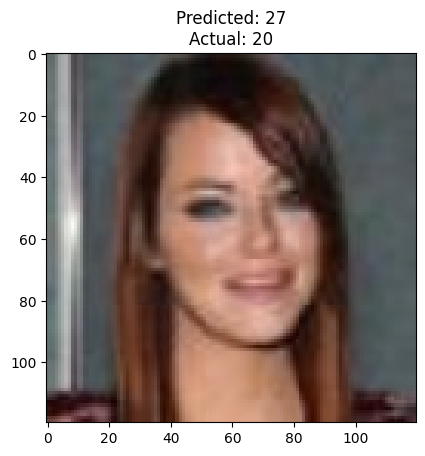

In [ ]:
import matplotlib.pyplot as plt

test_image = '/content/drive/MyDrive/AI/.kaggle/20-50/20-50/test/20/42331.jpg'
image = tf.keras.preprocessing.image.load_img(test_image, target_size=(120,120))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = model.predict(input_arr)

plt.figure()
plt.imshow(image)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = images['Age'][images[images['Filepath'] == test_image].index.values[0]].astype(str)

plt.title('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age)

plt.show()

1/1 [==============================] - 0s 28ms/step


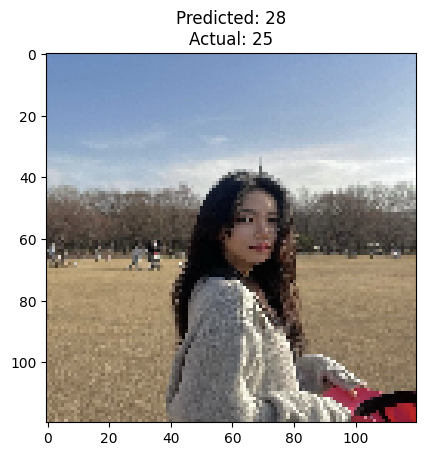

In [ ]:
test_image = '/content/drive/MyDrive/AI/AI_Project/FaceTest/test1.jpg'
image = tf.keras.preprocessing.image.load_img(test_image, target_size=(120,120))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = model.predict(input_arr)

plt.figure()
plt.imshow(image)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(25)
#actual_age = images['Age'][images[images['Filepath'] == test_image].index.values[0]].astype(str)

plt.title('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age)

plt.show()

1/1 [==============================] - 0s 19ms/step


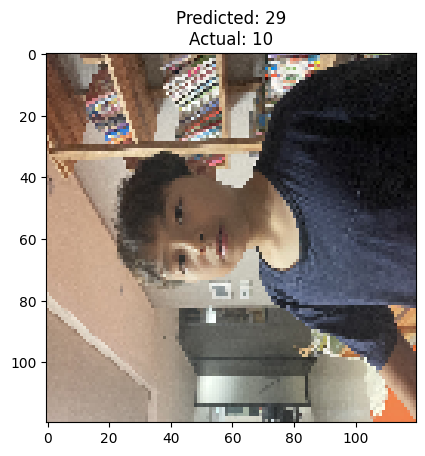

In [ ]:
test_image = '/content/drive/MyDrive/AI/AI_Project/FaceTest/test2.jpeg'
image = tf.keras.preprocessing.image.load_img(test_image, target_size=(120,120))
input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
predictions = model.predict(input_arr)

plt.figure()
plt.imshow(image)

predicted_age = predictions[0][0].astype(np.int32).astype(str)
actual_age = str(10)
#actual_age = images['Age'][images[images['Filepath'] == test_image].index.values[0]].astype(str)

plt.title('Predicted: ' + predicted_age + '\n' +
         'Actual: ' + actual_age)

plt.show()